# Resnet_Model

In [ ]:
import os

# Create the embedding_models directory if it doesn't exist
if not os.path.exists("embedding_models"):
  os.makedirs("embedding_models")

# Download the file (if it doesn't already exist)
file_path = "embedding_models/resnet50.pt"
if not os.path.exists(file_path):
  !wget https://raw.githubusercontent.com/mariakesa/NeuroFarm/main/embedding_models/resnet50.pt -O {file_path}

--2024-11-08 15:35:35--  https://raw.githubusercontent.com/mariakesa/NeuroFarm/main/embedding_models/resnet50.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94403311 (90M) [application/octet-stream]
Saving to: ‘embedding_models/resnet50.pt’

embedding_models/re 100%[===================>]  90.03M   161MB/s    in 0.6s    

2024-11-08 15:35:38 (161 MB/s) - ‘embedding_models/resnet50.pt’ saved [94403311/94403311]



In [ ]:
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                "BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(
                    replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


'''
def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            script_dir + "/state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model
'''


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:

        embedding_models_dir = os.path.join("embedding_models")
        state_dict_path = os.path.join(embedding_models_dir, arch + ".pt")
        state_dict = torch.load(state_dict_path, map_location=device)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )

# Prepare_data

In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import transforms as T
import numpy as np


# Assume `model` is your pretrained ResNet-50 model
model = resnet50(pretrained=True)
# print(next(model.parameters()))
model.eval()


def extract_features(model, x):
    # Put the model in evaluation mode
    model.eval()

    # Forward pass through the network
    with torch.no_grad():
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)

        x = model.avgpool(x)
        representation = torch.flatten(x, 1)
        representation = model.fc(representation)

    return representation


def make_transform():
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2471, 0.2435, 0.2616)

    # Step 1: Load CIFAR-10 dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Normalize images as per ResNet-50 requirements
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    '''
    transform = T.Compose(
        [
            # T.RandomCrop(32, padding=4),
            # T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(mean, std),
        ]
    )
    '''
    return transform


def make_data():

    transform = make_transform()

    train_dataset = datasets.CIFAR10(
        root='data/', train=True, download=True, transform=transform)
    # Count occurrences of each class
    class_counts = {i: 0 for i in range(10)}  # CIFAR-10 has 10 classes
    subset_indices = []
    labels_vector = []

    # Iterate through the dataset and collect indices for 100 images per class
    for idx, (img, label) in enumerate(train_dataset):
        if class_counts[label] < 10:
            subset_indices.append(idx)
            labels_vector.append(label)  # Track the label of each image
            class_counts[label] += 1
        if all(count == 10 for count in class_counts.values()):
            break

    # Create a SubsetRandomSampler based on collected indices
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, sampler=subset_sampler)

    # Step 2: Embedding all images in the training set
    embeddings = []
    batch_size = 10  # Adjust batch size based on your system's memory

    # Ensure model is in evaluation mode

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            outputs = extract_features(model, inputs)
            embeddings.append(outputs)

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(data_loader)} images")

    # Concatenate embeddings from all images into a single tensor
    embeddings_tensor = torch.cat(embeddings, dim=0)
    # Convert labels_vector to a numpy array for easy manipulation if needed
    labels_vector = np.array(labels_vector)

    # Concatenate embeddings from all batches into a single tensor
    embeddings_tensor = torch.cat(embeddings, dim=0)
    embeddings_tensor = embeddings_tensor.numpy()

    print(f"Embeddings shape: {embeddings_tensor.shape}")
    print(labels_vector.shape)

    # Save the embeddings and labels to disk
    np.save('logits_cifar10.npy', embeddings_tensor)
    np.save('labels_cifar10.npy', labels_vector)


if __name__ == "__main__":
    make_data()

<ipython-input-2-b452e7ce207e>:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=device)


100%|██████████| 170M/170M [00:04<00:00, 34.3MB/s]


Extracting data/cifar-10-python.tar.gz to data/
Processed 10/100 images
Processed 20/100 images
Processed 30/100 images
Processed 40/100 images
Processed 50/100 images
Processed 60/100 images
Processed 70/100 images
Processed 80/100 images
Processed 90/100 images
Processed 100/100 images
Embeddings shape: (100, 10)
(100,)


# Agents

In [ ]:
import random
from collections import namedtuple
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward', 'hidden', 'next_hidden', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
import torch.optim as optim

class TransformerDQNAgent:
    def __init__(self, config_dict):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = TransformerQNetwork(
            config_dict['state_size'],
            config_dict['hidden_size'],
            config_dict['action_size']
        ).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config_dict.get('lr', 0.001))
        self.criterion = nn.MSELoss()
        self.memory = ReplayMemory(config_dict['capacity'])

        # Initialize epsilon for exploration
        self.epsilon = config_dict.get('eps_start', 0.99)
        self.eps_end = config_dict.get('eps_end', 0.01)
        self.eps_decay = config_dict.get('eps_decay', 0.995)

    def select_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if torch.rand(1).item() < epsilon:
            return torch.randint(0, self.q_network.fc.out_features, (1,)).item(), None
        with torch.no_grad():
            return self.q_network(state.unsqueeze(0))[0].argmax().item(), None

    def update_epsilon(self):
        if self.epsilon > self.eps_end:
            self.epsilon *= self.eps_decay
    def store_transition(self, state, action, next_state, reward, hidden, next_hidden, done):
        # Adds transition to replay memory
        self.memory.push(state, action, next_state, reward, hidden, next_hidden, done)

    def learn(self):
        if len(self.memory) < self.memory.capacity / 10:  # Minimum memory threshold
            return

        batch = self.memory.sample(32)  # Batch size from replay memory
        states, actions, next_states, rewards, dones = zip(*batch)

        # Prepare tensors
        states = torch.cat(states).to(self.device)
        actions = torch.tensor(actions).to(self.device)
        next_states = torch.tensor(next_states).to(self.device)

        # Apply temporal difference model learning with updates
        batch = self.memory.sample(self.batch_size)

        targets = rewards + (1 - dones) * self.gamma * self.target_network(next_states).max(1).values
        predictions = self.q_network(states).gather(1, actions.unsqueeze(1))

    def optimize_model(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.cat(states)
        next_states = torch.cat(next_states)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        current_q = self.q_network(states)[0].gather(1, actions)
        next_q = self.q_network(next_states)[0].max(1)[0].detach().unsqueeze(1)
        target_q = rewards + (1 - dones) * 0.99 * next_q

        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save_model(self, model_path):
        torch.save({
            'model_state_dict': self.q_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, model_path)

# Environment

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class DelaySampleToMatchEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, n_stimuli=5, delay_length=1):
        super(DelaySampleToMatchEnv, self).__init__()

        # Number of different stimuli (excluding the delay)
        self.n_stimuli = n_stimuli

        # Length of delay between stimuli
        self.delay_length = delay_length

        # Action space and observation space
        # Stimuli are represented as integers from 0 to n_stimuli (0 is the delay)
        self.action_space = spaces.Discrete(n_stimuli + 1)
        self.observation_space = spaces.Discrete(n_stimuli + 1)

        # Initialize the sequence and current step
        self.sequence = []
        self.current_step = 0
        self.first_stimulus = None

    def _generate_sequence(self):
        # Randomly select n stimuli (1 to n_stimuli, excluding 0 which is the delay)
        stimuli = np.random.choice(
            range(1, self.n_stimuli + 1), self.n_stimuli, replace=False)

        self.first_stimulus = stimuli[0]
        # Create the sequence: stimulus1-delay-stimulus2-delay-...-stimulusN-stimulus1
        sequence = [0]
        for stimulus in stimuli:
            sequence.append(stimulus)
            sequence.extend([0] * self.delay_length)  # 0 represents the delay
        sequence.append(stimuli[0])
        # print(sequencep)
        return sequence

    def reset(self):
        # Generate a new sequence for the episode
        self.sequence = self._generate_sequence()
        self.current_step = 0
        # Return the first stimulus
        return self.sequence[self.current_step]

    def step(self, action):
        reward = 0
        done = False

        # If the action is non-zero and the current stimulus is a delay, give a reward of -1
        if action != 0 and self.sequence[self.current_step] == 0:
            reward = -1

        if self.current_step < len(self.sequence) - 1:
            if action != 0:
                # print('boom')
                reward = -1
            else:
                reward = 0

        # If the current step is the last one, check if the action matches the first stimulus
        if self.current_step == len(self.sequence) - 1:
            done = True
            # print(self.sequence, self.sequence[self.current_step])
            if action == self.first_stimulus:
                reward = 10
            else:
                reward = -1

        # Advance to the next step
        self.current_step += 1

        # Check if the episode is done
        done = self.current_step >= len(self.sequence)

        # Get the next observation
        if not done:
            observation = self.sequence[self.current_step]
        else:
            observation = 0

        return observation, reward, done, {}

    def render(self, mode='human'):
        if self.current_step < len(self.sequence):
            print(
                f"Step {self.current_step}: Stimulus {self.sequence[self.current_step]}")
        else:
            print("Episode finished.")


'''
# Example usage
env = DelaySampleToMatchEnv(n_stimuli=15, delay_length=1)
observation = env.reset()
done = False

while not done:
    print("Current Observation:", observation)
    action = env.action_space.sample()  # Random action (for demonstration purposes)
    observation, reward, done, info = env.step(action)
    env.render()
    print(f"Action: {action}, Reward: {reward}")

env.close()
'''

'\n# Example usage\nenv = DelaySampleToMatchEnv(n_stimuli=15, delay_length=1)\nobservation = env.reset()\ndone = False\n\nwhile not done:\n    print("Current Observation:", observation)\n    action = env.action_space.sample()  # Random action (for demonstration purposes)\n    observation, reward, done, info = env.step(action)\n    env.render()\n    print(f"Action: {action}, Reward: {reward}")\n\nenv.close()\n'

# eval_scripts

In [ ]:

import numpy as np
import torch
import time

def prepare_data():
    train_data = np.load('logits_cifar10.npy')
    train_labels = np.load('labels_cifar10.npy')

    # Adjust train_labels as per the original intent (adding 1)
    train_labels = train_labels + 1

    # Create a row of zeros with the same number of columns as train_data
    zeros_row = np.zeros((1, train_data.shape[1],))
    train_data = torch.tensor(
        np.vstack((zeros_row, train_data)), dtype=torch.float32).to(device="cuda" if torch.cuda.is_available() else "cpu")

    # Append the label corresponding to the zeros row
    train_labels = np.hstack((0, train_labels))

    # Create a dictionary to store indices of each class
    class_dct = {i: np.where(train_labels == i)[0] for i in range(12)}

    return train_data, class_dct

def cifar_eval(config_dict):
    train_data, class_dct = prepare_data()

    start = time.time()
    n_stimuli = config_dict['action_size'] - 1
    env = DelaySampleToMatchEnv(n_stimuli=n_stimuli)

    if config_dict['q_network'] == TransformerQNetwork:
        agent = TransformerDQNAgent(config_dict)
    else:
        raise ValueError("Unsupported Q-Network type provided in config_dict.")

    # Evaluation logic to be added here

    end = time.time()
    print(f"Evaluation completed in {end - start:.2f} seconds.")



# Q Network

In [ ]:

import torch.nn as nn

class TransformerQNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, nhead=4):
        super(TransformerQNetwork, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # (batch_size, hidden_size)

        if x.dim() == 2:  # Add sequence dimension if missing
            x = x.unsqueeze(1)  # (batch_size, seq_len=1, hidden_size)

        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = self.fc(x[-1])  # Use the last time step's representation
        return x, None


    def init_hidden(self):
        return None


# train

In [ ]:

import numpy as np
import torch
import torch.nn.functional as F
import time


def move_tuple_to_device(hidden_tuple, device):
    return (hidden_tuple[0].to(device), hidden_tuple[1].to(device))


def vanilla_train(config_dict):
    start = time.time()
    n_stimuli = config_dict['state_size'] - 1
    env = DelaySampleToMatchEnv(n_stimuli=n_stimuli)

    if config_dict['q_network'] == TransformerQNetwork:
        agent = TransformerDQNAgent(config_dict)
    else:
        raise ValueError("Unsupported Q-Network type provided in config_dict.")

    n_episodes = config_dict['train_steps']
    episode_rewards = []
    scores = []

    for i in range(n_episodes):
        state = env.reset()
        agent.update_epsilon()
        state = F.one_hot(torch.tensor(state), env.observation_space.n).to(dtype=torch.float32, device=agent.device)
        done = False
        score = 0
        hidden = agent.q_network.init_hidden()

        while not done:
            action, _ = agent.select_action(state, epsilon=agent.epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = F.one_hot(torch.tensor(next_state), env.observation_space.n).to(
                dtype=torch.float32, device=agent.device
            )
            agent.store_transition(state, action, next_state, reward, hidden, None, done)
            agent.learn()
            state = next_state
            score += reward

        scores.append(score)

        if i % 100 == 0:
            avg_score = np.mean(scores[-100:])
            episode_rewards.append(avg_score)
            print(f"Episode {i} - Average Score: {avg_score:.2f}")

    end = time.time()

    # Pass model path to save_model
    agent.save_model(config_dict['model_path'])

    print(f'It took {end-start:.2f} seconds to train the model')
    np.save(config_dict['learning_curve_path'], episode_rewards)



def cifar_train(config_dict):
    train_data, class_dct = prepare_data()

    start = time.time()
    n_stimuli = config_dict['action_size'] - 1
    env = DelaySampleToMatchEnv(n_stimuli=n_stimuli)

    if config_dict['q_network'] == TransformerQNetwork:
        agent = TransformerDQNAgent(config_dict)
    else:
        raise ValueError("Unsupported Q-Network type provided in config_dict.")

    n_episodes = config_dict['train_steps']
    episode_rewards = []
    scores = []

    for i in range(n_episodes):
        done = False
        state = env.reset()
        indices = class_dct[int(state)]
        random_index = np.random.choice(indices)
        state = train_data[random_index].flatten()
        score = 0

        while not done:
            action, _ = agent.select_action(state, None)
            next_state, reward, done, _ = env.step(action)
            indices = class_dct[int(next_state)]
            random_index = np.random.choice(indices)
            next_state = train_data[random_index].flatten()
            agent.store_transition(state, action, next_state, reward, None, None, done)
            agent.learn()
            state = next_state
            score += reward

        scores.append(score)

        if i % 100 == 0:
            avg_score = np.mean(scores[-100:])
            episode_rewards.append(avg_score)
            print(f"Episode {i} - Average Score: {avg_score:.2f}")

    end = time.time()
    agent.save_model(config_dict['model_path'])
    print(f'It took {end-start:.2f} seconds to train the model')
    np.save(config_dict['learning_curve_path'], episode_rewards)


def mnist_train(config_dict):
    pass


# experiments

In [ ]:
import torch.nn as nn

# Define configurations and parameters
configurations = [
    ("short-seq", "easy-seq"),
    # ("short-seq", "mnist-seq"),
    ("short-seq", "cifar10-seq"),
    ("long-seq", "easy-seq"),
    # ("long-seq", "mnist-seq"),
    ("long-seq", "cifar10-seq")
]

networks = {
    "Transformer": TransformerQNetwork  # Use TransformerQNetwork instead of RNN/LSTM
}

losses = {
    "MSELoss": nn.MSELoss,
    # "SmoothL1Loss": nn.SmoothL1Loss
}

state_sizes = {
    "short-seq": 6,
    "long-seq": 11
}

train_functions = {
    "easy-seq": vanilla_train,
    # "mnist-seq": mnist_train,
    "cifar10-seq": cifar_train
}

# Generate experiments dictionary
experiments = {}

for seq_type, env_type in configurations:
    for loss_name, loss_fn in losses.items():
        for net_name, net_class in networks.items():
            config_key = (seq_type, env_type, loss_name, net_name)
            lr = 0.001 if seq_type == 'short-seq' else 0.0001

            if env_type == 'easy-seq':
                state_size = state_sizes[seq_type]
                action_size = state_size
            elif env_type == 'cifar10-seq':
                state_size = 10  # CIFAR-10 logits dimension
                action_size = 6 if seq_type == 'short-seq' else 11

            hidden_size = 64 if seq_type == "short-seq" else 128
            model_path = f"{seq_type}_{env_type}_{loss_name}_{net_name}.pth"
            learning_curve_path = f"{seq_type}_{env_type}_{loss_name}_{net_name}.npy"
            train_function = train_functions[env_type]

            experiments[config_key] = {
                'q_network': net_class,
                'loss': loss_fn,
                'state_size': state_size,
                'action_size': action_size,
                'hidden_size': hidden_size,
                'capacity': 100000,
                'batch_size': 32,
                'lr': lr,
                'gamma': 0.99,
                'model_path': model_path,
                'learning_curve_path': learning_curve_path,
                'mode': 'train-from-zero',
                'train_function': train_function,
                'train_steps': 200
            }


In [ ]:
def run_experiment(experiment):
    train = experiment['train_function']
    train(experiment)


for key, value in experiments.items():
    print(key, value)
    run_experiment(value)

('short-seq', 'easy-seq', 'MSELoss', 'Transformer') {'q_network': <class '__main__.TransformerQNetwork'>, 'loss': <class 'torch.nn.modules.loss.MSELoss'>, 'state_size': 6, 'action_size': 6, 'hidden_size': 64, 'capacity': 100000, 'batch_size': 32, 'lr': 0.001, 'gamma': 0.99, 'model_path': 'short-seq_easy-seq_MSELoss_Transformer.pth', 'learning_curve_path': 'short-seq_easy-seq_MSELoss_Transformer.npy', 'mode': 'train-from-zero', 'train_function': <function vanilla_train at 0x7b6a93a4b910>, 'train_steps': 200}
Episode 0 - Average Score: 1.00
Episode 100 - Average Score: -9.27
It took 2.65 seconds to train the model
('short-seq', 'cifar10-seq', 'MSELoss', 'Transformer') {'q_network': <class '__main__.TransformerQNetwork'>, 'loss': <class 'torch.nn.modules.loss.MSELoss'>, 'state_size': 10, 'action_size': 6, 'hidden_size': 64, 'capacity': 100000, 'batch_size': 32, 'lr': 0.001, 'gamma': 0.99, 'model_path': 'short-seq_cifar10-seq_MSELoss_Transformer.pth', 'learning_curve_path': 'short-seq_cifa

# plot_test

(2,)


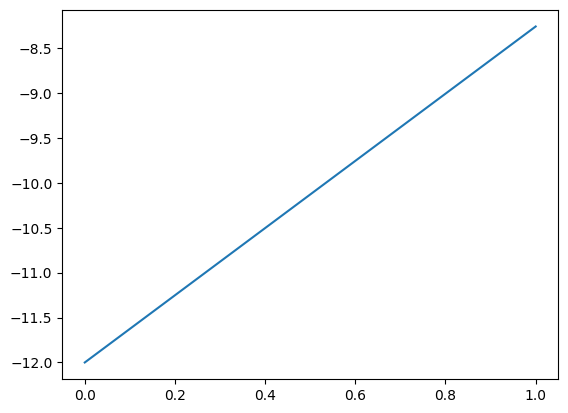

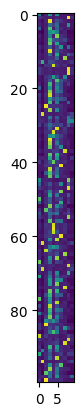

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dat = np.load(
    'short-seq_cifar10-seq_MSELoss_Transformer.npy')
print(dat.shape)
plt.plot(dat)
plt.show()

dat = np.load('logits_cifar10.npy')
# dat = np.load('/home/maria/NeuroFarm/cifar10_task/logits/embeddings copy.npy')

plt.imshow(dat)
plt.show()

(2,)


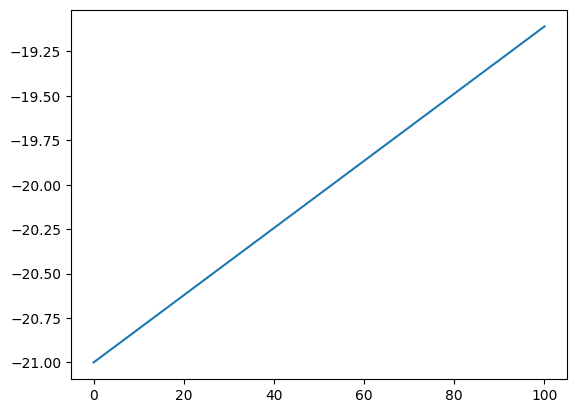

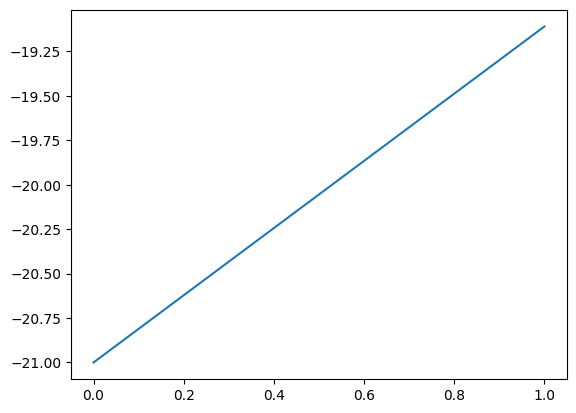

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dat = np.load(
    'short-seq_cifar10-seq_MSELoss_Transformer.npy')
dat = np.load(
    'short-seq_easy-seq_MSELoss_Transformer.npy')
dat = np.load(
    'long-seq_cifar10-seq_MSELoss_Transformer.npy')
dat = np.load(
    'long-seq_easy-seq_MSELoss_Transformer.npy')
print(dat.shape)

rng = np.arange(0, dat.shape[0]) * 100
plt.plot(rng, dat)
plt.show()
plt.plot(dat)

# plots

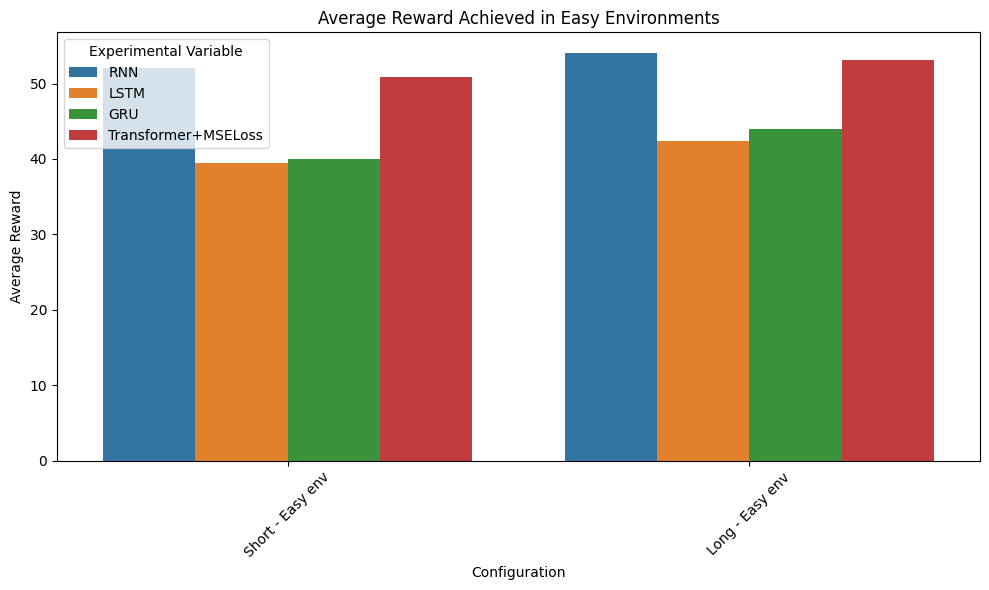

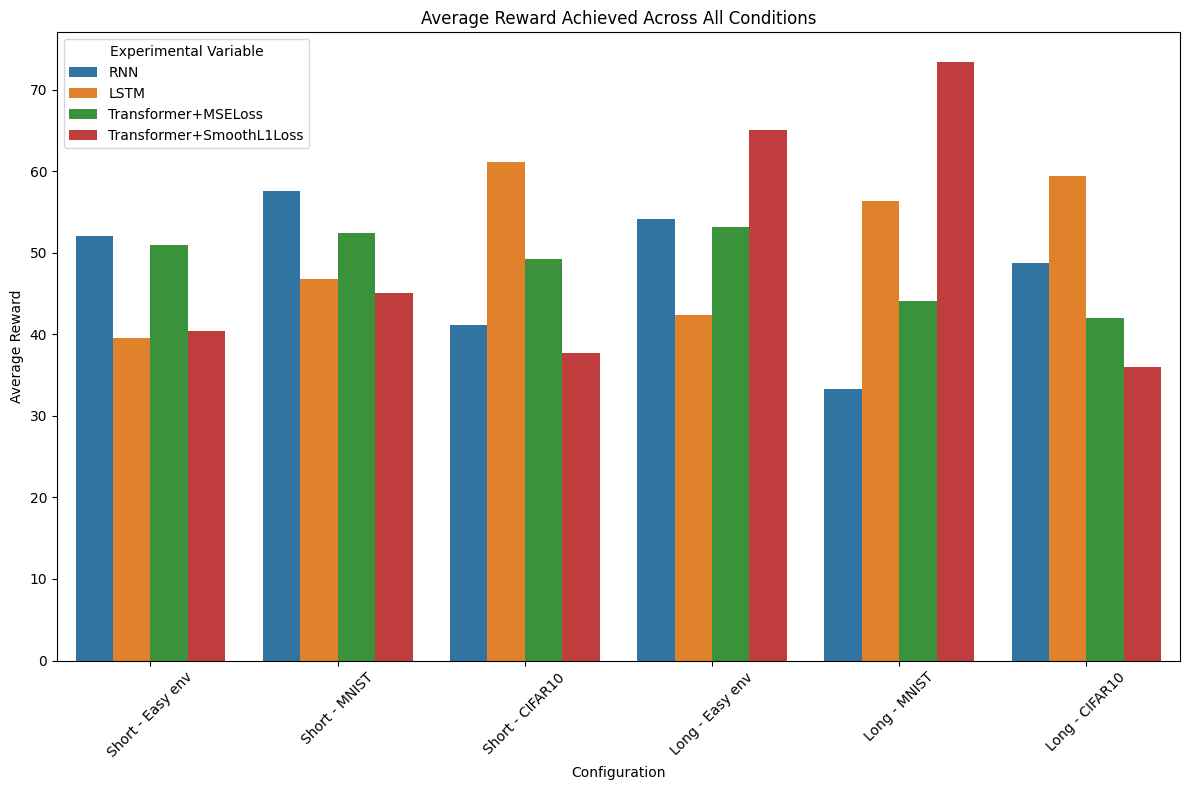

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Define the experiments and categories
configurations = [
    "Short - Easy env",
    "Short - MNIST",
    "Short - CIFAR10",
    "Long - Easy env",
    "Long - MNIST",
    "Long - CIFAR10"
]

experimental_variables = [
    "RNN",
    "LSTM",
    "GRU",
    "Transformer+MSELoss",
    "Transformer+SmoothL1Loss"
]

# Generate random rewards for each experiment and each variable
data = []
for config in configurations:
    for var in experimental_variables:
        # average reward between 0 and 100
        reward = np.random.rand(10).mean() * 100
        data.append([config, var, reward])

# Create a DataFrame
df = pd.DataFrame(
    data, columns=["Configuration", "Experimental Variable", "Average Reward"])

# Plot 1: Short and Long Easy Environments with RNN, LSTM, GRU, and Transformer
filtered_data_easy_env = df[(df["Configuration"].isin(["Short - Easy env", "Long - Easy env"])) &
                            (df["Experimental Variable"].isin(["RNN", "LSTM", "GRU", "Transformer+MSELoss"]))]

plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_data_easy_env, x="Configuration",
            y="Average Reward", hue="Experimental Variable")
plt.title("Average Reward Achieved in Easy Environments")
plt.xticks(rotation=45)
plt.legend(title="Experimental Variable")
plt.tight_layout()
plt.show()

# Plot 2: All Conditions with Transformer Variants and Comparisons
filtered_data_all_conditions = df[df["Experimental Variable"].isin(["Transformer+MSELoss", "Transformer+SmoothL1Loss", "LSTM", "RNN"])]

plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_data_all_conditions, x="Configuration",
            y="Average Reward", hue="Experimental Variable")
plt.title("Average Reward Achieved Across All Conditions")
plt.xticks(rotation=45)
plt.legend(title="Experimental Variable")
plt.tight_layout()
plt.show()


# ratermap and pca

In [ ]:
experiment = experiments[('short-seq', 'cifar10-seq', 'MSELoss', 'Transformer')]
env = DelaySampleToMatchEnv(n_stimuli=experiment['action_size'] - 1)
agent = TransformerDQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 100
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden().to(agent.device)
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        hids.append(hidden.detach().cpu().numpy())


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


AttributeError: 'TransformerDQNAgent' object has no attribute 'load_model'

In [ ]:
!pip install rastermap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 5.8 MB/s eta 0:00:00


(64, 1200)
Number of constant rows: 2


/usr/local/lib/python3.10/dist-packages/rastermap/rastermap.py:278: RuntimeWarning: invalid value encountered in divide
  X /= stdx[:,np.newaxis]


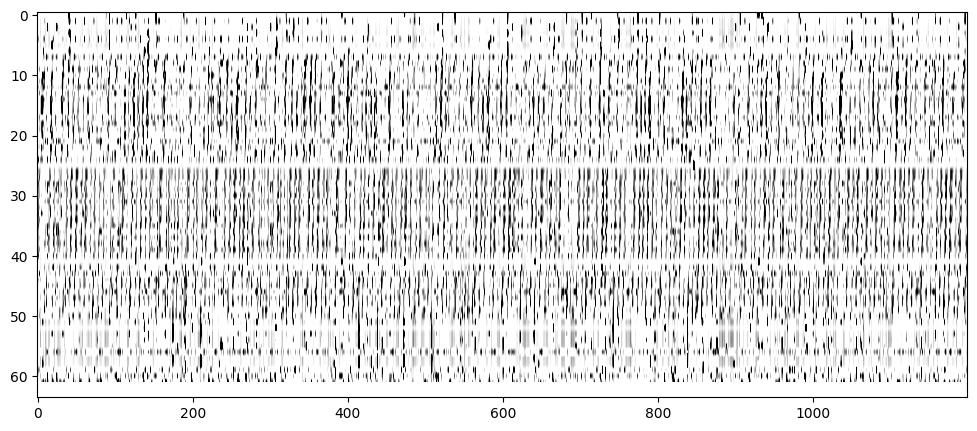

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

spks=hids.T
print(spks.shape)

# Identify constant rows
constant_rows = np.std(spks, axis=1) == 0
print(f"Number of constant rows: {np.sum(constant_rows)}")

# Remove constant rows
spks_clean = spks[~constant_rows, :]

# Apply zscore after removing constant rows
spks_clean = zscore(spks_clean, axis=1)


# fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5,
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

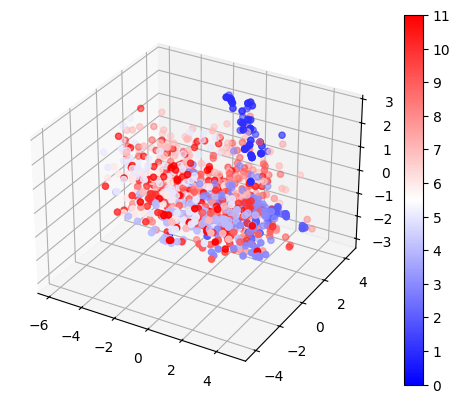

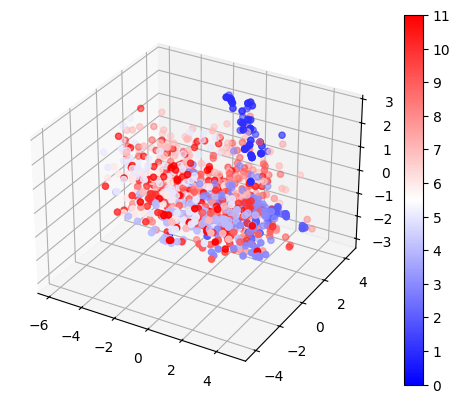

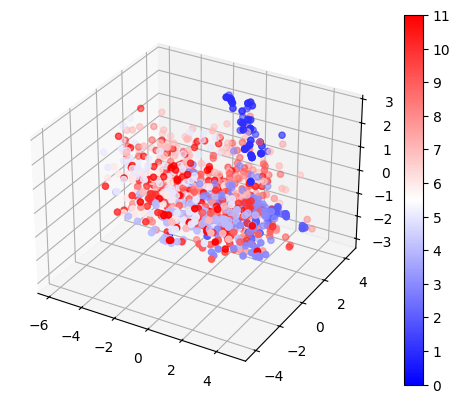

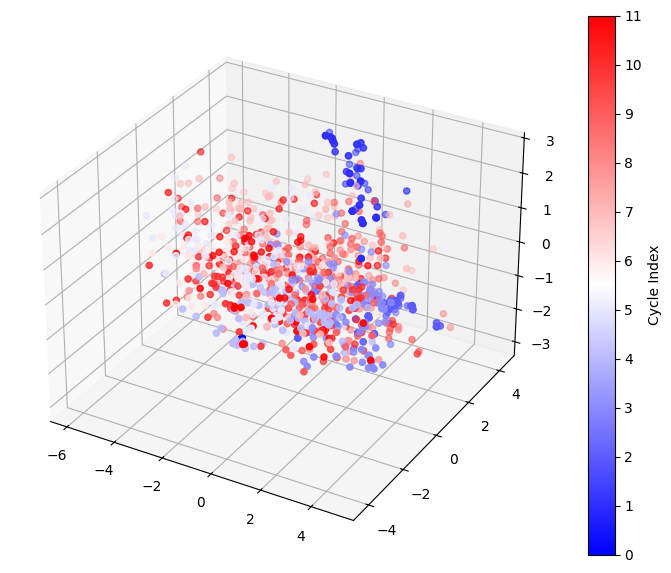

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # Ensure 3D plotting support

# Inline plotting for Colab
%matplotlib inline

# Assuming `hids` is already defined
pca = PCA(n_components=3, svd_solver='full')
pcs = pca.fit_transform(hids)

# Create a repeating pattern of indices for colors
num_points = len(pcs)
cycle_length = 12
indices = np.arange(num_points) % cycle_length

# Normalize the indices to fit within the range of the colormap
norm = Normalize(vmin=0, vmax=cycle_length-1)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2], c=indices, cmap='bwr', norm=norm)

# Add a colorbar
cbar = plt.colorbar(scatter, ticks=range(cycle_length))
cbar.set_label('Cycle Index')

# Display the plot
plt.show()


# test

In [ ]:

import torch.nn as nn

class TransformerQNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, nhead=4):
        super(TransformerQNetwork, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # (batch_size, seq_len, hidden_size)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, hidden_size)
        x = self.transformer_encoder(x)
        x = self.fc(x[-1])  # Use the last time step's representation
        return x, None

    def init_hidden(self):
        return None


In [ ]:
def move_tuple_to_device(hidden_tuple, device):
    return (hidden_tuple[0].to(device), hidden_tuple[1].to(device))


experiment = experiments[('short-seq', 'cifar10-seq', 'MSELoss', 'LSTM')]
env = DelaySampleToMatchEnv(n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 10
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden()
    if isinstance(hidden, tuple):
        hidden = move_tuple_to_device(hidden, agent.device)
    else:
        hidden = hidden.to(agent.device)
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        if isinstance(hidden, tuple):
            hids.append(hidden[0].detach().cpu().numpy())
        else:
            hids.append(hidden.detach().cpu().numpy())


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)

<ipython-input-4-450843e9e398>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.load_path)


LSTMQNetwork(
  (rnn): LSTM(10, 64)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
(120, 64)
[[ 1.32844274e-04  2.69875675e-02  8.86743784e-01 ...  9.18853223e-01
   6.79312050e-02  1.54042661e-01]
 [-6.15106463e-01  1.83404684e-01  2.77728617e-01 ...  2.74441421e-01
  -5.73904991e-01 -3.36903274e-01]
 [ 8.38750079e-02  1.40901983e-01  3.93107057e-01 ...  3.73214841e-01
  -2.01635256e-01 -8.10852870e-02]
 ...
 [ 2.99687445e-01 -5.47904730e-01  2.77480423e-01 ...  2.35392809e-01
   8.63773644e-01 -4.30185139e-01]
 [ 1.12545826e-01 -5.45681655e-01  3.76231968e-01 ...  3.47422481e-01
   6.01723969e-01  6.56836703e-02]
 [ 2.47093633e-01 -6.51159167e-01  3.74404550e-01 ...  1.88507050e-01
   7.49435544e-01 -3.21359009e-01]]


(64, 120)


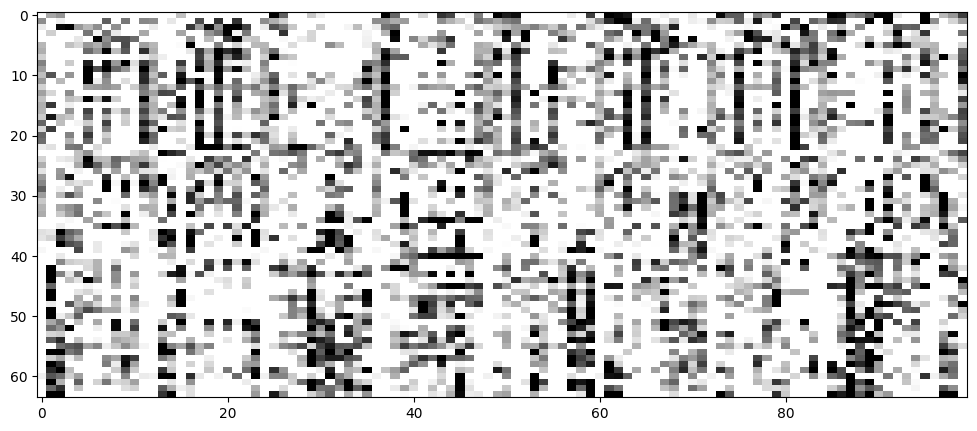

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

spks=hids.T
print(spks.shape)
spks = zscore(spks, axis=1)
spks=spks[:,:100]
# fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5,
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

(120, 64)


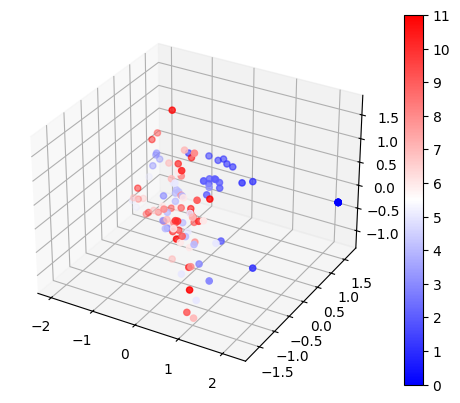

In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline

pca = PCA(n_components=3, svd_solver='full')
#n_samples, n_features
print(hids.shape)
pcs=pca.fit_transform(hids)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Create a repeating pattern of indices for colors
num_points = len(pcs)
cycle_length = 12
indices = np.arange(num_points) % cycle_length

# Normalize the indices to fit within the range of the colormap
norm = Normalize(vmin=0, vmax=cycle_length-1)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2], c=indices, cmap='bwr', norm=norm)
plt.colorbar(scatter, ticks=range(cycle_length))
plt.show()

In [ ]:
def move_tuple_to_device(hidden_tuple, device):
    return (hidden_tuple[0].to(device), hidden_tuple[1].to(device))


experiment = experiments[('short-seq', 'cifar10-seq', 'MSELoss', 'LSTM')]
env = DelaySampleToMatchEnv(n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 10
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden()
    if isinstance(hidden, tuple):
        hidden = move_tuple_to_device(hidden, agent.device)
    else:
        hidden = hidden.to(agent.device)
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        if isinstance(hidden, tuple):
            hids.append(hidden[1].detach().cpu().numpy())
        else:
            hids.append(hidden.detach().cpu().numpy())


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)

LSTMQNetwork(
  (rnn): LSTM(10, 64)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
(120, 64)
[[ 0.0375668   0.93283343  1.7571747  ...  1.7903512   0.96018136
   0.7145988 ]
 [ 0.08373336  0.7548367   2.414499   ...  1.6987563   0.8451989
   0.3847793 ]
 [ 0.038355    0.5157547   2.7065084  ...  1.7131115   1.0672171
  -0.20626627]
 ...
 [ 0.23087175 -1.0259852   4.100694   ...  1.4721179   1.6578443
  -0.7005658 ]
 [ 0.21395735 -1.1448299   3.8538425  ...  1.398787    1.6210958
  -0.300281  ]
 [-0.37584955 -1.0678082   3.3466973  ...  1.1603515   1.6139753
   0.5032605 ]]


<ipython-input-4-450843e9e398>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.load_path)


(64, 120)


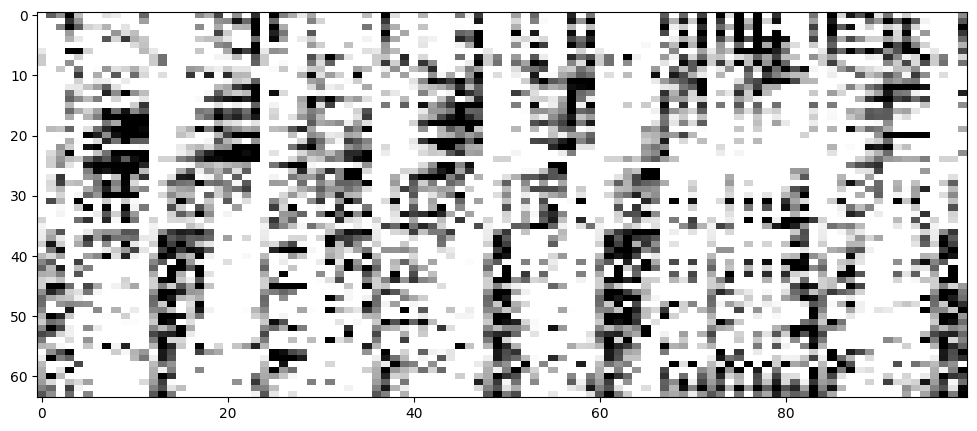

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

spks=hids.T
print(spks.shape)
spks = zscore(spks, axis=1)
spks=spks[:,:100]
# fit rastermap
model = Rastermap(n_PCs=10, n_clusters=5,
                  locality=0.75, time_lag_window=5).fit(spks, compute_X_embedding=True)
y = model.embedding # neurons x 1
isort = model.isort

# visualize binning over neurons
X_embedding = model.X_embedding

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")

# Visualization

<ipython-input-4-450843e9e398>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.load_path)


RNNQNetwork(
  (rnn): RNN(10, 64)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
(1200, 64)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.19076096 0.         0.         ... 0.         0.         0.        ]
 ...
 [1.0855254  1.9326649  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.31323415 0.         0.         ... 0.         1.059116   0.63311696]]
(1200, 64)


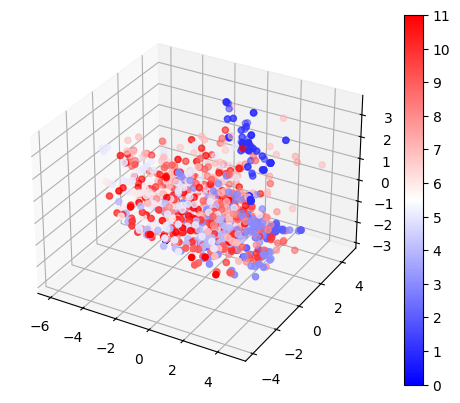

In [ ]:
experiment = experiments[('short-seq', 'cifar10-seq', 'MSELoss', 'RNN')]
env = DelaySampleToMatchEnv(n_stimuli=experiment['action_size'] - 1)
agent = DQNAgent(experiment)

agent.load_model('eval')

agent.epsilon = 0.00

print(agent.q_network)

n_episodes = 100
win_pct_list = []
scores = []
hids = []

train_data, class_dct = prepare_data()

for i in range(n_episodes):
    done = False
    state = env.reset()  # Reset the environment
    indices = class_dct[int(state)]
    random_index = np.random.choice(indices)
    state = train_data[random_index].flatten()
    score = 0
    hidden = agent.q_network.init_hidden().to(agent.device)
    while not done:
        action, next_hidden = agent.select_action(state, hidden)
        next_state, reward, done, info = env.step(action)  # Take the action
        indices = class_dct[int(next_state)]
        random_index = np.random.choice(indices)
        next_state = train_data[random_index].flatten()
        hidden = next_hidden
        # hids.append(hidden)
        state = next_state  # Move to the next state
        score += reward
        hids.append(hidden.detach().cpu().numpy())


hids = np.array(hids).squeeze(1).squeeze(1)
print(hids.shape)
print(hids)


from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
# n_samples, n_features
print(hids.shape)
pcs = pca.fit_transform(hids)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Create a repeating pattern of indices for colors
num_points = len(pcs)
cycle_length = 12
indices = np.arange(num_points) % cycle_length

# Normalize the indices to fit within the range of the colormap
norm = Normalize(vmin=0, vmax=cycle_length - 1)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2],
                     c=indices, cmap='bwr', norm=norm)
plt.colorbar(scatter, ticks=range(cycle_length))
plt.show()